# For processing UV-Vis spectroelectrochemistry data
### Rajiv Giridharagopal, rgiri@uw.edu

You can run this notebook by hitting **shift-click** on each cell (including this one!)

In [ ]:
import uvvis
import cv
from matplotlib import pyplot as plt
import numpy as np
import scipy as sps
import pickle
import pandas as pd
from pathlib import Path # added by DW for multiple OS folder deliminator

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (16, 8)

### Set up Data paths and global processing variables

In [5]:
# 1) Set up the data path

# Windows example: r'C:\Users\Raj\OneDrive\Documents\Word\uvvis'
# Linux example: '/home/name/path/to/dataset/20191206'
# MacOS example: '/Users/name/path/to/dataset/20191206'
# 'r' is for raw treatment of the string so '\' is not interpreted as a control character

#data_path = r'/Users/waldow/Downloads/20191206/R4'

# don't edit this
#if data_path == 'COPY_PATH_TO_FOLDER_HERE':
from oect_load import file_open
data_path = file_open(caption='Select folder to load from')
print('Loading from', data_path)

# 2) Select the wavelength for extracting kinetics, and the potential for plotting time-dependent spectra
wavelength = 500
potential = 0.7

# 3) For saving the figures, add a small string to the filename. e.g. "20190825". By default it's blank
filenamestring = ''

# 4) Save path. By default this will just be in the data path
path = data_path
data_folder = Path(data_path)

Loading from C:/Users/Raj/OneDrive/UW Work/Coding and Signal Processing Work/Python/OECT/test_data/Raj Python Files/20191212 R1


In [6]:
# This block reads all the text files and saves them as a list of file paths for Python to read
#   Steps = the voltage steps. Not actually needed but it contains the current
#   Specs = spectra
#   Volts = potentials extracted from the steps files

steps, specs, volts, dedopesteps, dedopespecs = uvvis.read_files(data_folder)

## 1. Process Data!

#### Here's what this block does:

First, we load the data as a uvvis object
> data = uvvis.uvvis(steps, specs, volts)

1) Now, we process the data by reading in all the spectra at each voltage.  
This step takes all the spectra and saves the time=0 s (initial) spectra at each voltage as a big matrix
It then extracts absorbance vs voltage at a specific wavelength. The command below is at 500 nm
> data.spec_echem_voltage(wavelength=500)

2) Then, we create a giant dictionary that contains a huge matrix of each time-dependent spectra  
> data.time_dep_spectra()

To access the 0.7 V, for example, you'd run this then type 
> data.spectra_vs_time[0.7]

3) Finally, we extract a single time-dependent kinetics trace. Edit the potential and wavelength (wl) based on your data. The command below plots the kinetics for the 0.7 V case and wavelength=500 nm:
> data.single_wl_time(wavelength = 500, potential = 0.7)

4) As an option, we can extract the current from the 'steps' files. This is not that critical
> data.current_vs_time()

Lastly, this saves the data as 2 ".PKL" (pickle) files, dopingdata.pkl and dedopingdata.pkl. It's ~120 MB as opposed to 2 GB, and contains all the data!

In [8]:
# Load Data

# Did you already load any data? If so, this avoids reprocessing. You can manually override this by changing to True
overwrite = True

if not overwrite:
    try:

        working_path = data_folder / "dopingdata.pkl"
        with open(working_path, 'rb') as input:

            data = pickle.load(input)
        print('Loaded existing doping data')

        working_path = data_folder / "dedopingdata.pkl"

        with open(working_path, 'rb') as input:
            dedata = pickle.load(input)
            
        print('Loaded existing dedoping data')
        print('If you REALLY want to re-process all the data, change overwrite to True. You should not need to do this.')
        
    except:
        overwrite = True

if overwrite:
    ####### LOAD DATA ######
    data = uvvis.uv_vis(steps, specs, volts)

    # Actual processing of data. This takes a long time!!
    print('Processing data...hold on!')
    
    # Time-dependent spectra
    print('Generating spectra vs time')
    try:
        data.time_dep_spectra(specfiles=specs) 
    except:
        print('time-dependent spectra failed')
    
    # Single wavelength kinetics
    print('Extracting single wavelength kinetics')
    try:
        data.single_wl_time(wavelength=wavelength, potential=potential)
    except:
        print('single wavelength spectra failed')
        
    # Integrated current
    print('Current extraction')
    try:
        data.current_vs_time(stepfiles=steps)
        print('Total integrated charge at each voltage')
        print(data.charge)
    except:
        data.charge=[0]
        print('current extraction failed')
        
    # Time slice spectra
    print('Single DataFrame of time slice t=0')
    try:
        data.spec_echem_voltage(time=0)
    except:
        print('time-slice spectra failed')
    
    working_path = data_folder / "dopingdata.pkl"
    with open(working_path, 'wb') as output:

        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

    #### DEDOPING DATA ######
        
    if any(dedopespecs):
        dedata = uvvis.uv_vis(dedopesteps, dedopespecs, volts)
        print('### Dedoping Data ###' )
        
        print('Processing data...hold on!')
        print('Generating spectra vs time')
        
        
        # Time-dependent spectra
        print('Generating spectra vs time')
        try:
            dedata.time_dep_spectra(specfiles=dedopespecs) 
        except:
            print('time-dependent spectra failed')

        # Single wavelength kinetics
        print('Extracting single wavelength kinetics')
        try:
            dedata.single_wl_time(wavelength=wavelength, potential=potential)
        except:
            print('single wavelength spectra failed')
        # Integrated current
        print('Current extraction')
        try:
            dedata.current_vs_time(stepfiles=dedopesteps)
            print('Total integrated charge at each voltage')
            print(data.charge)
        except:
            dedata.charge=[0]
            print('current extraction failed')
        
        # Time slice spectra
        print('Single DataFrame of time slice t=0')
        try:
            dedata.spec_echem_voltage(time=0)
        except:
            print('time-slice spectra failed')
    
        working_path = data_folder / "dedopingdata.pkl"
        with open(working_path, 'wb') as output:

    
            pickle.dump(dedata, output, pickle.HIGHEST_PROTOCOL)
    else:
        dedata = [] # flag for later
print('This section is done!')

Processing data...hold on!
Generating spectra vs time
Extracting single wavelength kinetics
Current extraction
Total integrated charge at each voltage
Potential (V)       0.0       0.1       0.2       0.3       0.4       0.5  \
0              0.333355 -0.074816 -0.823977 -1.554871 -2.296974 -3.179394   

Potential (V)       0.6       0.7  
0             -4.165534 -4.902202  
Single DataFrame of time slice t=0
### Dedoping Data ###
Processing data...hold on!
Generating spectra vs time
Generating spectra vs time
Extracting single wavelength kinetics
Current extraction
Total integrated charge at each voltage
Potential (V)       0.0       0.1       0.2       0.3       0.4       0.5  \
0              0.333355 -0.074816 -0.823977 -1.554871 -2.296974 -3.179394   

Potential (V)       0.6       0.7  
0             -4.165534 -4.902202  
Single DataFrame of time slice t=0
This section is done!


In [10]:
# Saves as an HDF5, more flexible than a Pickle
import h5py

working_path = data_folder / 'dopingdata.h5'
with h5py.File(working_path, 'w') as f:
    dset = f.create_dataset('potentials', (len(data.potentials),))
    dset[:] = data.potentials[:]
    dset = f.create_dataset('charge', (len(data.charge.values[0]),))
    dset[:] = data.charge.values[0][:]
f.close()

working_path = data_folder / 'dopingdata.h5'
for p in data.spectra_vs_time:
    data.spectra_vs_time[p].to_hdf(working_path, key='x'+str(p), mode='a')
    
data.current.to_hdf(data_folder / 'dopingdata.h5', key ='current', mode='a')

working_path = data_folder / 'dedopingdata.h5'
#with h5py.File(data_path+'/dedopingdata.h5', 'w') as f:
with h5py.File(working_path, 'w') as f:
    dset = f.create_dataset('potentials', (len(dedata.potentials),))
    dset[:] = dedata.potentials[:]
    dset = f.create_dataset('charge', (len(dedata.charge.values[0]),))
    dset[:] = dedata.charge.values[0][:]
f.close()

working_path = data_folder / 'dedopingdata.h5'
for p in dedata.spectra_vs_time:
    data.spectra_vs_time[p].to_hdf(working_path, key='x'+str(p), mode='a')
dedata.current.to_hdf(data_folder / 'dedopingdata.h5', key ='current', mode='a')

## 2. Cool Plots!

### First, simple spectra vs voltage

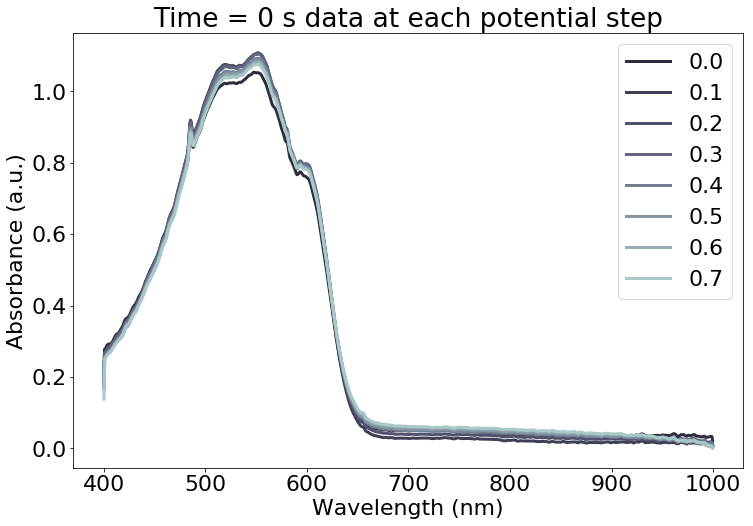

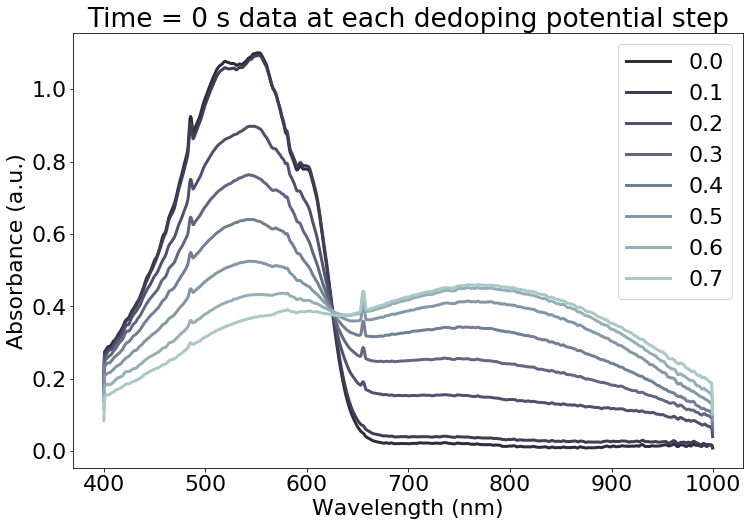

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8), facecolor='white')
plt.rcParams.update({'font.size': 22})

# This block just generates a cool colormap
# In the last line, you can replace "bone" with any colormap name from here: 
#     https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
cm = np.linspace(0.2,0.75,len(data.spectra_sm.columns))
for i,cl in zip(data.spectra_sm, cm):
    ax.plot(data.spectra_sm[i], linewidth=3,
           color=plt.cm.bone(cl))  

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (a.u.)')
ax.legend(labels = data.potentials)
ax.set_title('Time = 0 s data at each potential step')

plot_name =  'Doping Spectra, t=0 s'+filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Doping Spectra, t=0 s'+filenamestring+'.jpg')
plt.savefig(working_path)

if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8), facecolor='white')
    plt.rcParams.update({'font.size': 22})

    # This block just generates a cool colormap
    # In the last line, you can replace "bone" with any colormap name from here: 
    #     https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cm = np.linspace(0.2,0.75,len(data.spectra_sm.columns))
    for i,cl in zip(dedata.spectra_sm, cm):
        ax.plot(dedata.spectra_sm[i], linewidth=3,
               color=plt.cm.bone(cl))  

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.legend(labels = dedata.potentials)
    ax.set_title('Time = 0 s data at each dedoping potential step')

    plot_name = 'Dedoping Spectra, t=0 s'+filenamestring+'.jpg'
    working_path = data_folder / plot_name
#    plt.savefig(path + r'//' + 'Dedoping Spectra, t=0 s'+filenamestring+'.jpg')
    plt.savefig(working_path)



### Now, let's plot spectra vs time for a particular voltage.
##### Change this line
> potential = 0.7 
##### to whatever voltage you want to plot the kinetics of

"\nendtime = data.spectra_vs_time[potential].columns[-1]\ncm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))\nfor i,cl in zip(data.spectra_vs_time[potential], cm):\n    ax.plot(data.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))\n    \nax.set_xlabel('Wavelength (nm)')\nax.set_ylabel('Absorbance (a.u.)')\nax.set_title(str(potential) +' V doping kinetics over ' + str(endtime) + ' s')\n\nplot_name = 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg'\nworking_path = data_folder / plot_name\n#plt.savefig(path + r'//' + 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')\nplt.savefig(working_path)\n\n\nif dedata:\n    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')\n\n    #potential = 0.7 # Change this to whatever voltage you want to plot\n\n    endtime = dedata.spectra_vs_time[potential].columns[-1]\n    cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potent

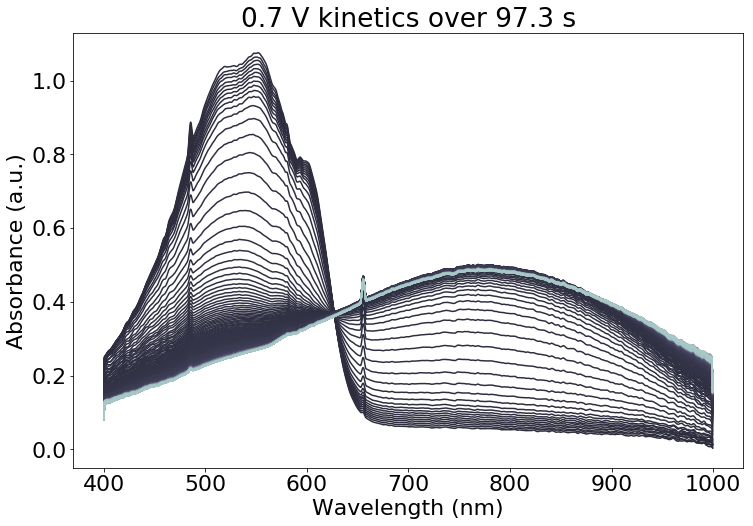

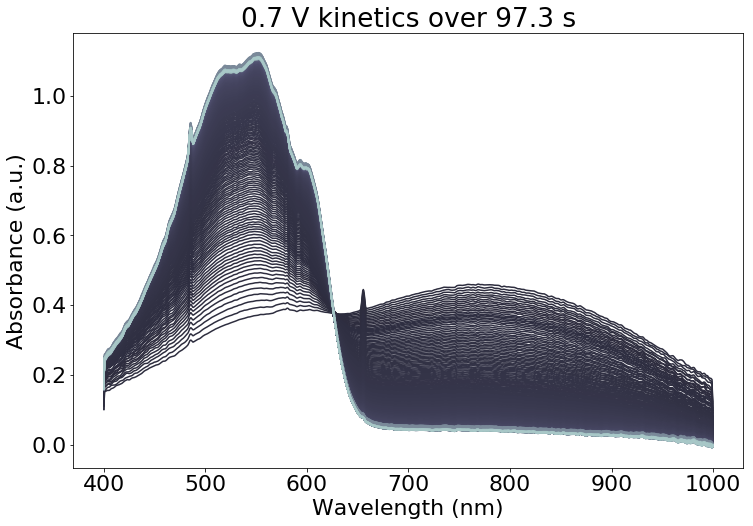

In [17]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')

potential = 0.7 # Change this to whatever voltage you want to plot

ax = uvvis.plot_spectra_vs_time(data, ax=ax, potential=potential, crange=[0.2, 0.75])
plot_name = 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg'
working_path = data_folder / plot_name
plt.savefig(working_path)

if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
    ax = uvvis.plot_spectra_vs_time(dedata, ax=ax, potential=potential, crange=[0.2, 0.75])

    plot_name = 'Dedoping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg'
    working_path = data_folder / plot_name
    plt.savefig(working_path)

    
# If you'd like more control, here's the code behind the plot_spectra_vs_time function
'''
endtime = data.spectra_vs_time[potential].columns[-1]
cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))
for i,cl in zip(data.spectra_vs_time[potential], cm):
    ax.plot(data.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))
    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (a.u.)')
ax.set_title(str(potential) +' V doping kinetics over ' + str(endtime) + ' s')

plot_name = 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')
plt.savefig(working_path)


if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')

    #potential = 0.7 # Change this to whatever voltage you want to plot

    endtime = dedata.spectra_vs_time[potential].columns[-1]
    cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))
    for i,cl in zip(dedata.spectra_vs_time[potential], cm):
        ax.plot(dedata.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.set_title(str(potential) +' V dedoping kinetics over ' + str(endtime) + ' s')

    plot_name = 'Dedoping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg'
    working_path = data_folder / plot_name
#    plt.savefig(path + r'//' + 'Dedoping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')
    plt.savefig(working_path)

'''



### Plot the kinetics at a particular wavelength and voltage

##### Change these lines
> potential = 0.7  
> wavelength = 800  
##### to whatever voltage and wavelength you want

In [ ]:
def exp_fit(t, y, A, tau):
    return y + A * np.exp(-t / tau)

In [ ]:
# Changes these two lines to whatever potential and wavelength you want
potential = 0.7
wavelength = 820

data.single_wl_time(potential=potential, wavelength = wavelength)
# How to save data...???
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
uvvis.plot_time(data, ax=ax, **{'color':'r', 'linewidth': 3})
ax.set_title('Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V')

plot_name = 'Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V' +filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V'
#            +filenamestring+'.jpg')
plt.savefig(working_path)


if dedata:
    dedata.single_wl_time(potential=potential, wavelength = wavelength)
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
    uvvis.plot_time(dedata, ax=ax, **{'color':'r', 'linewidth': 3})
    ax.set_title('Dedoping Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V')

    plot_name = 'Dedope Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V'+filenamestring+'.jpg'
    working_path = data_folder / plot_name    
#    plt.savefig(path + r'//' + 'Dedope Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V'
#                +filenamestring+'.jpg')
    plt.savefig(working_path)
    
fig, ax1 = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
uvvis.plot_voltage(data, ax=ax1, time=0, **{'color':'r', 'linewidth': 0, 'marker':'s'})
ax1.set_title('Threshold at ' + str(wavelength) + ' nm')

plot_name = 'Threshold at ' + str(wavelength) + ' nm' +filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Threshold at ' + str(wavelength) + ' nm' +filenamestring+'.jpg')
plt.savefig(working_path)


### Plot the kinetics over a band of wavelengths at a given voltage and/or charge integrated

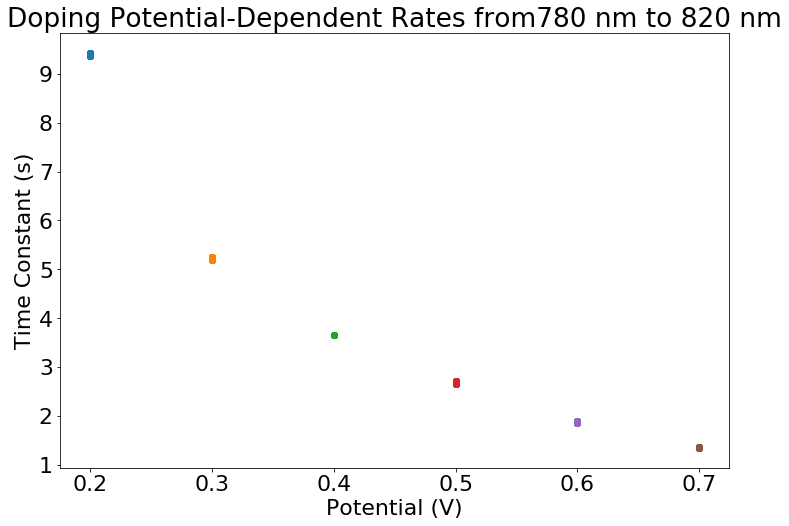

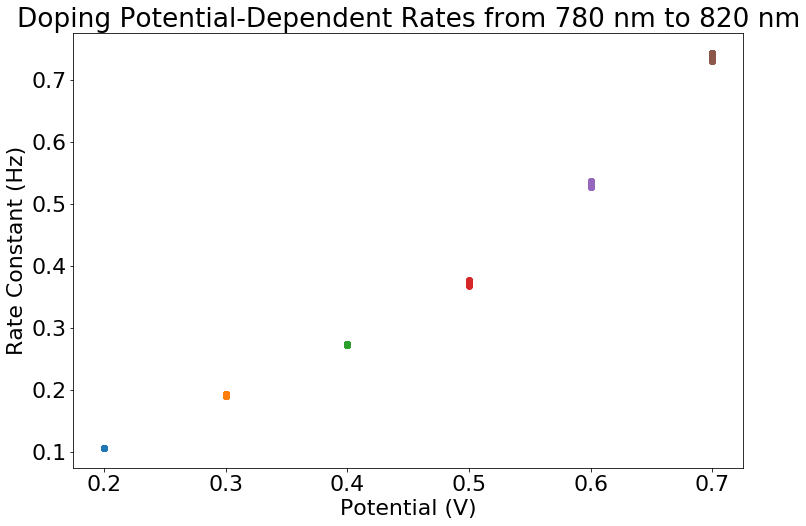

In [18]:
#Choose wavelengths to plot about
wl_start = 780
wl_stop = 820
potentials = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
times = {}

# Setup variables for saving data as CSV - DW
potential_volt = []
time_constant_ave = []
std_tc = []
tc_array = []

fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    
# DW for all fits to csv
    filename_var = "all_tcs_"+str(p)+".csv"
    save_name_path =  data_folder  / filename_var
    np.savetxt(save_name_path, times[p], delimiter=",")
# DW for initial arrays
    potential_volt.append(p)
    time_constant_ave.append(np.mean(times[p]))
    std_tc.append(np.std(times[p]))    
    
    ax.plot(p * np.ones(len(data.fits)), data.fits, 'o')

# DW - Save voltage, ave, and stdev to csv
#
# Implement Operating System Neutal Path Method
filename_var = "tc_mean_range.csv"
save_name_path =  data_folder  / filename_var
tc_array = np.vstack((potential_volt, time_constant_ave,std_tc)).T
np.savetxt(save_name_path, tc_array, delimiter=",")    
    
ax.set_ylabel('Time Constant (s)')
ax.set_xlabel('Potential (V)')
ax.set_title('Doping Potential-Dependent Rates from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')

plot_name = 'Doping Potential-Dependent Kinetics from '+str(wl_start)+' nm to '+str(wl_stop )+' nm'+filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'/' + 'Doping Potential-Dependent Kinetics from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
#            +filenamestring+'.jpg')
plt.savefig(working_path)

            
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(p * np.ones(len(data.fits)), np.array(data.fits)**-1, 'o')
    
ax.set_ylabel('Rate Constant (Hz)')
ax.set_xlabel('Potential (V)')
ax.set_title('Doping Potential-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')

plot_name = 'Doping Potential-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'+filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'/' + 'Doping Potential-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
#            +filenamestring+'.jpg')
plt.savefig(working_path)

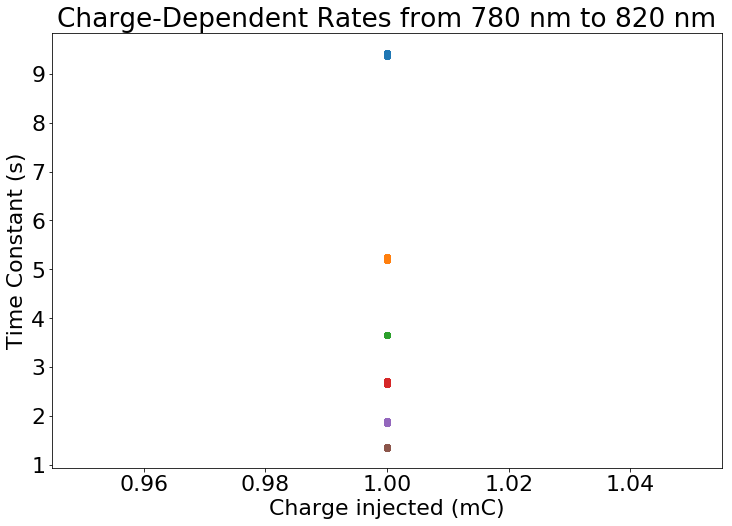

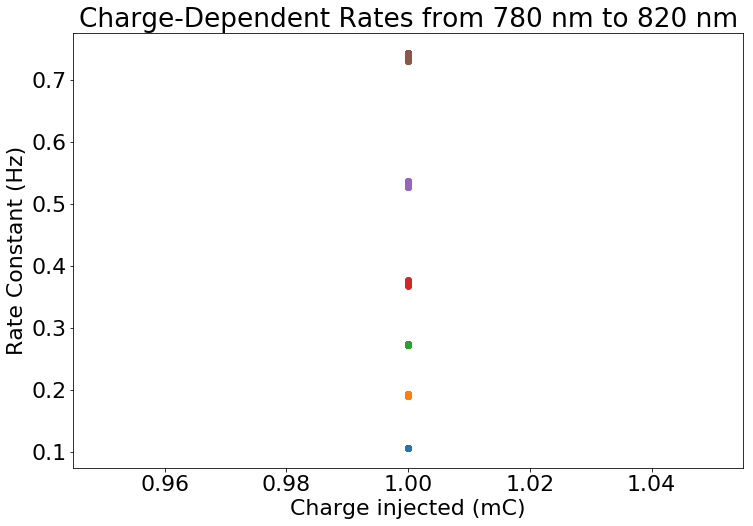

In [19]:
#Choose wavelengths to plot about
wl_start = 780
wl_stop = 820
potentials = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

times = {}

fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(data.charge[p].values * np.ones(len(data.fits)), data.fits, 'o')
    
ax.set_ylabel('Time Constant (s)')
ax.set_xlabel('Charge injected (mC)')
ax.set_title('Charge-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')

plot_name = 'Doping Charge-Dependent Kinetics from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'+filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'/' + 'Doping Charge-Dependent Kinetics from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
#            +filenamestring+'.jpg')
plt.savefig(working_path)

            
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(data.charge[p].values * np.ones(len(data.fits)), np.array(data.fits)**-1, 'o')

    
ax.set_ylabel('Rate Constant (Hz)')
ax.set_xlabel('Charge injected (mC)')
ax.set_title('Charge-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')

plot_name =  'Doping Charge-Dependent Rates from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'+filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'/' + 'Doping Charge-Dependent Rates from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
#            +filenamestring+'.jpg')
plt.savefig(working_path)

### Plot the kinetics as a rad-looking spectrogram

#### These data are not actually any different from the above kinetics data

In [ ]:
# Change potential to whatever voltage you want
# change cmap only if you know what that means
potential = 0.7
kwargs = {}
kwargs['cmap'] = 'icefire'

# Sets up two dataframes for plotting
import pandas as pd
import seaborn as sns
wl = np.round(data.spectra_vs_time[potential].index.values, 2)
df = pd.DataFrame.copy(data.spectra_vs_time[potential])
df = df.set_index(wl)
dfv = pd.DataFrame.copy(data.spectra_sm)
dfv = dfv.set_index(wl)

# spectra vs time
fig, ax0 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
sns.heatmap(df,ax=ax0, **kwargs)    
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Wavelength (nm)')

plot_name = 'Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg')
plt.savefig(path + r'//' + 'Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg')

# spectra vs voltage
fig, ax1 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
sns.heatmap(dfv,ax=ax1, **kwargs)    
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Wavelength (nm)')

plot_name =  'Spectrogram at t = 0 s' +filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Spectrogram at t = 0 s' +filenamestring+'.jpg')
plt.savefig(working_path)

In [ ]:
if dedata:
        # Change potential to whatever voltage you want
    # change cmap only if you know what that means
    #potential = 0.7
    kwargs = {}
    kwargs['cmap'] = 'icefire'

    # Sets up two dataframes for plotting
    import pandas as pd
    import seaborn as sns
    wl = np.round(dedata.spectra_vs_time[potential].index.values, 2)
    df = pd.DataFrame.copy(dedata.spectra_vs_time[potential])
    df = df.set_index(wl)
    dfv = pd.DataFrame.copy(dedata.spectra_sm)
    dfv = dfv.set_index(wl)

    # spectra vs time
    fig, ax0 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
    sns.heatmap(df,ax=ax0, **kwargs)    
    ax0.set_xlabel('Time (s)')
    ax0.set_ylabel('Wavelength (nm)')
   
    
    plot_name = 'Dedoping Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg'
    working_path = data_folder / plot_name
#    plt.savefig(path + r'//' + 'Dedoping Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg')
    plt.savefig(working_path)


    # spectra vs voltage
    fig, ax1 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
    sns.heatmap(dfv,ax=ax1, **kwargs)    
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Wavelength (nm)')

    plot_name = 'Dedoping Spectrogram at t = 0 s' +filenamestring+'.jpg'
    working_path = data_folder / plot_name
#    plt.savefig(path + r'//' + 'Dedoping Spectrogram at t = 0 s' +filenamestring+'.jpg')
    plt.savefig(working_path)
    

## 3. A brief tour through what this all contains for your reference

## (This part is not necessary to run)

In [ ]:
# data.spectra -- the data as one large dataframe vs voltage
data.spectra

In [ ]:
# All the spectra vs time
data.spectra_vs_time

In [ ]:
data.time_spectra_norm # normalized time-dependent spectra

In [ ]:
data.time_spectra # un-normalized time-dependent spectra

### This cell saves to a csv file the time dependance at all wavelengths and one voltage.

In [ ]:
data.spectra_vs_time[0.6].T.to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data6test.csv') 


### This cell extracts the time dependance at a specific wavelength and voltage.

In [ ]:
wavelength = 500.12 # must be exact key
potential = 0.2
wavelength_choice = str(wavelength)
data_name = 'abs_vs_time_'+str(potential)+ ' at '+str(wavelength) + ' nm'+'.csv'
working_path = data_folder / data_name
data.spectra_vs_time[0.7].T[wavelength].to_csv(working_path)
#data.spectra_vs_time[0.7].T[800.14].to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data7_R4_800.csv')

In [ ]:
data.spectra_vs_time[0.7].T # to find wavelength values of interest or save the data to a csv file.

In [ ]:
# Saves to working path
potential = 0.2
data_name = 'All_abs_vs_time_'+str(potential)+'.csv'
working_path = data_folder / data_name
data.spectra_vs_time[0.2].T.to_csv(working_path) 

In [ ]:
data.spectra_vs_time[0.7].T[800.14].to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data7_R4_800.csv')

In [ ]:
data.spectra_vs_time[0.7].T

In [ ]:
print(data.single_wl_time(0.2,780))

In [ ]:
uvvis.plot_voltage(data)

### The following are examples of saving the time dependance of all wavelengths at a specific voltage.

In [ ]:
data.spectra_vs_time[0.2].T.to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data2_R4b.csv') 

In [ ]:
data.spectra_vs_time[0.3].T.to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data3_R4b.csv') 

In [ ]:
data.spectra_vs_time[0.4].T.to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data4_R4b.csv') 

In [ ]:
data.spectra_vs_time[0.5].T.to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data5_R4b.csv') 

In [ ]:
data.spectra_vs_time[0.6].T.to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data6_R4b.csv') 

In [ ]:
data.spectra_vs_time[0.7].T.to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data7_R4b.csv') 

In [ ]:
data.fits

In [ ]:
data.spectra_vs_time[0.2].T

In [ ]:
data.spectra_vs_time[0.7].T[800.14].to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data7_R4_800.csv')

In [ ]:
data.banded_fits

In [ ]:
data.fits

In [ ]:
np.argmax(data.spectra_vs_time[0.2].T.loc[0.0]) # Find wavelength of max abs of potential '0.2'

In [ ]:
data.spectra_vs_time[0.2].T.loc[0.2] # all wavelengths at a certain time.

In [ ]:
# Find wavelength of max abs of potential '0.2'
print (np.argmax(data.spectra_vs_time[0.2].T.loc[0.0]))
# Find max abs of potential '0.2'
print (np.max(data.spectra_vs_time[0.2].T.loc[0.0]))
#
print (np.std(data.spectra_vs_time[0.2].T.loc[0.0]))

In [ ]:
#Test code to save an average of fits and all individual fits over the wavelength range from an above cell

wl_start = 780
wl_stop = 820
potentials = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# Setup variables for saving data as CSV - DW
potential_volt = []
time_constant_ave = []
std_tc = []
tc_array = []

for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    
# DW for all fits to csv
    filename_var = "all_tcs_"+str(p)+".csv"
    save_name_path =  data_folder  / filename_var
    np.savetxt(save_name_path, times[p], delimiter=",")
# DW for initial arrays
    potential_volt.append(p)
    time_constant_ave.append(np.mean(times[p]))
    std_tc.append(np.std(times[p]))

# DW - Save voltage, ave, and stdev to csv
#
# Implement Operating System Neutal Path Method
filename_var = "tc_mean_range.csv"
save_name_path =  data_folder  / filename_var
tc_array = np.vstack((potential_volt, time_constant_ave,std_tc)).T
np.savetxt(save_name_path, tc_array, delimiter=",")

 


In [ ]:
times[0.2] # fits over range at a specific voltage

In [ ]:
data.fits # last fits of results over wavelength range

In [ ]:
np.mean(times[0.7]) # average of time constants at a voltage

In [ ]:
np.array(data.fits)**-1 # rate constants over wavelength range in a numpy array

In [ ]:
data.fits**-1 # rate constants over wavelength range as basic array

In [ ]:
# save time constants as csv
np.savetxt("/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/times7_R4_780-820.csv", times[0.7], delimiter=",")

In [ ]:
times[0.2].T # Transpose of time constants array though not likely useful.

In [ ]:
# Saves the mean of the time constants saved as a csv
np.savetxt("/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/test3.csv", [np.mean(times[0.2])], delimiter=",")